# Dynamic breakpoints 

In [37]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

Updated graph structure:


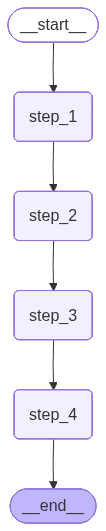

In [38]:
from IPython.display import Image, display
import re # Import the regular expression module

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        # Keep original logic for step 2 interruption
        print(f"---Step 2 INTERRUPT (length > 5): Input '{state['input']}'---")
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")

    print("---Step 2---")
    return state

def step_3(state: State) -> State:
# Check if the input contains any digit
    if re.search(r'\d', state['input']):
        print(f"---Step 3 INTERRUPT (contains number): Input '{state['input']}'---")
        raise NodeInterrupt(f"Input contains a number: {state['input']}")

    print("---Step 3---")
    return state


def step_4(state: State) -> State:
    print("---Step 4---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_node("step_4", step_4) 

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", "step_4") 
builder.add_edge("step_4", END)  

# Set up memory (no change needed)
memory = MemorySaver()

# Compile the graph with memory (no change needed)
graph = builder.compile(checkpointer=memory)

# View the updated graph
print("Updated graph structure:")
display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
initial_input = {"input": "hello123"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello123'}
---Step 1---
{'input': 'hello123'}
---Step 2 INTERRUPT (length > 5): Input 'hello123'---
{'__interrupt__': (Interrupt(value='Received input that is longer than 5 characters: hello123', id='placeholder-id'),)}


C:\Users\ACER\AppData\Local\Temp\ipykernel_23232\1683853883.py:21: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")


In [40]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


In [41]:
print(state.tasks)

(PregelTask(id='8acecd44-31e9-6d1c-cf35-0087f63ae768', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello123', id='placeholder-id'),), state=None, result=None),)


We can try to resume the graph from the breakpoint. 

But, this just re-runs the same node! 

Unless state is changed we will be stuck here.

In [42]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello123'}
---Step 2 INTERRUPT (length > 5): Input 'hello123'---
{'__interrupt__': (Interrupt(value='Received input that is longer than 5 characters: hello123', id='placeholder-id'),)}


C:\Users\ACER\AppData\Local\Temp\ipykernel_23232\1683853883.py:21: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")


In [43]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


Now, we can update state.

In [44]:
graph.update_state(
    thread_config,
    {"input": "yo123"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b2b3d-f519-6abf-8002-223058a64ccd'}}

In [46]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'yo123'}
---Step 2---
{'input': 'yo123'}
---Step 3 INTERRUPT (contains number): Input 'yo123'---
{'__interrupt__': (Interrupt(value='Input contains a number: yo123', id='placeholder-id'),)}


C:\Users\ACER\AppData\Local\Temp\ipykernel_23232\1683853883.py:30: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Input contains a number: {state['input']}")


In [47]:
graph.update_state(
    thread_config,
    {"input": "yooo"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b2b3d-f584-62ef-8004-5894ddb0c18d'}}

In [48]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'yooo'}
---Step 3---
{'input': 'yooo'}
---Step 4---
{'input': 'yooo'}


### Usage with LangGraph API


In [49]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

We connect to it via the SDK.

In [50]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

ConnectError: All connection attempts failed

In [ ]:
thread = await client.threads.create()
input_dict = {"input": "hello world"}

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=input_dict,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef6a43a-1b04-64d0-9a79-1caff72c8a89'}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'input': 'hello world'}





In [ ]:
current_state = await client.threads.get_state(thread['thread_id'])

In [ ]:
current_state['next']

['step_2']

In [ ]:
await client.threads.update_state(thread['thread_id'], {"input": "hi!"})

{'configurable': {'thread_id': 'ea8c2912-987e-49d9-b890-6e81d46065f9',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a43a-64b2-6e85-8002-3cf4f2873968'},
 'checkpoint_id': '1ef6a43a-64b2-6e85-8002-3cf4f2873968'}

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=None,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef64c33-fb34-6eaf-8b59-1d85c5b8acc9'}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}





In [ ]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'input': 'hi!'},
 'next': ['step_2'],
 'tasks': [{'id': '858e41b2-6501-585c-9bca-55c1e729ef91',
   'name': 'step_2',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 2,
  'source': 'update',
  'writes': {'step_1': {'input': 'hi!'}},
  'parents': {},
  'graph_id': 'dynamic_breakpoints'},
 'created_at': '2024-09-03T22:27:05.707260+00:00',
 'checkpoint_id': '1ef6a43a-64b2-6e85-8002-3cf4f2873968',
 'parent_checkpoint_id': '1ef6a43a-1cb8-6c3d-8001-7b11d0d34f00'}